# Concatenated Residual Convolutional Network
## Part 2: Demo for deblur real-world image where estimated kernel is not truth
This is a demo for CRCNet in our paper "Iterative Residual Image Deconvoluiton" (Si-Yao <i>et al.</i>, submitted to AAAI 2019). In this demo, 

The released codes and datasets are only permitted for non-comercial usage. Researchers who use these code or datasets are aksed to cite our paper.

Version 1.0, created by Li Si-Yao
Oct. 2018

In [1]:
import os
import glob
from PIL import Image
import torch
import torchvision
import numpy as np 
import torch.nn as nn
import torch.cuda as cuda
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.transforms as T 
import h5py
import math
import argparse
import copy
from CRCNet import CRCNet

import matplotlib.pyplot as plt

In [2]:
# Parameters

# select which kernel (1-10)
img_name = 'real_blur/lantern.png'
ker_name = 'real_blur/lantern_kernel.png'

# content loss trade-off
alpha = 5000

# edge loss trade-off
gamma = 100

# noise standard deviation added in training image
nstr = 2e-3

# noise std added into kernel during training
knstr = 2e-3

# initial learning rate
lr = 1e-3

# epochs to train
epoch_num = 20

# where to store your model
get_name = 'estimated_kernel_deblur_self_trained/'
if not os.path.isdir(get_name):
	os.mkdir(get_name)
file_store = get_name

# training image count 
image_num = 850

# training kernel count
kernel_num = 1

# batch size for training
batch_size = 32

# image patch size for training
patch_size = 35

# kernel size 
kernel_size = None

# input image size to generate patch_size blur by 'valid' convolution  
input_size = None

# iteration per epoch
iteration_num_per_epoch = 1000

# test image path
path = 'data/test_images/'


trans = T.ToTensor()

# prepare global variables
clear_images = None
test_images = None
kernels = None
kernels_test = None

model = CRCNet().cuda()

smoothl1 = nn.SmoothL1Loss()
dtype = cuda.FloatTensor

loss_recorder = []

## Predefined functions
ycbcr2rgb, rgb2ycbcr, generate_blur, psnr.

Note YCbCr used here is kept identical to MATLAB implementation. 

In [3]:
def rgb2ycbcr(rgb):
    m = np.array([[ 65.481, 128.553, 24.966],
                  [-37.797, -74.203, 112],
                  [ 112, -93.786, -18.214]])
    shape = rgb.shape
    if len(shape) == 3:
        rgb = rgb.reshape((shape[0] * shape[1], 3))
    ycbcr = np.dot(rgb, m.transpose() / 255.0)
    ycbcr[:, 0] += 16.0
    ycbcr[:, 1:] += 128.0
    return ycbcr.reshape(shape)


def ycbcr2rgb(ycbcr):
    m = np.array([[ 65.481, 128.553, 24.966],
                  [-37.797, -74.203, 112],
                  [ 112, -93.786, -18.214]])
    shape = ycbcr.shape
    if len(shape) == 3:
        ycbcr = ycbcr.reshape((shape[0] * shape[1], 3))
    rgb = ycbcr
    rgb[:, 0] -= 16.0
    rgb[:, 1:] -= 128.0
    rgb = np.dot(rgb, np.linalg.inv(m.transpose()) * 255.0)
    return rgb.clip(0, 255).reshape(shape)

def generate_blur(x, kernel, nstr=nstr, knstr=knstr, same=True):
    """
    This function generates blurry images from clear ones and corresponding kernels.
    Input:
        x: (N, C, H, W) images C should be 3 here
        kernel: (N, 1, Hk, Wk) kernels
        nstr: noise sigma added to blurry image
        knstr: noise sigma added to kernel
        same: whether convolution keeps result same size as x. If False, result will be with size of (N, C, H-Hk+1, W-Wk+1). 
    """
    N, C, H, W = x.size()
    kernel_size = kernel.size(2)
    
    # add aditional noise with strength knstr
    kernel += Variable(torch.randn(kernel.size()).cuda() * knstr)
        
    # expand the depth-1 kernels to C
    kernel_expanded = kernel
    for n in range(C - 1):
        kernel_expanded = torch.cat([kernel_expanded, kernel], dim=1)

    # convolute each layer
    if same:
        blur = F.conv2d(x.view(1, N*C, H, W), kernel_expanded.view(N*C, 1, kernel_size, kernel_size), padding=kernel_size//2, groups=N*C) 
        blur += Variable(torch.randn(blur.size()).cuda() * nstr) 
        blur = Variable(blur.data.view(N, C, H, W), requires_grad=False)
    
    else:
        blur = F.conv2d(x.view(1, N*C, H, W), kernel_expanded.view(N*C, 1, kernel_size, kernel_size), padding=0, groups=N*C) 
        blur += Variable(torch.randn(blur.size()).cuda() * nstr) 
        blur = Variable(blur.data.view(N, C, patch_size, patch_size), requires_grad=False)

    return blur

log10 = 1 / torch.log(dtype([10])).cpu().numpy()[0]

def psnr(x_hat, x):
    N, C, H, W = x.size()
    loss = 0
    for i in range(N):
        mse = F.mse_loss(255.0*x_hat[i].view(1, C, H, W), 255.0*x[i].view(1, C, H, W))
    
        if mse.data.cpu().numpy() == 0:
            loss += 100
            continue
        print(float(20 * torch.log(255.0 / torch.sqrt(mse)).data.cpu().numpy() *log10))
        loss += 20 * torch.log(255.0 / torch.sqrt(mse)) *log10
    loss /= N
    return loss

## Reading datas
The proposed training image set contains 850 255x255 images, which are contatenated into h5 file "data/sharp_color_image.h5". For training CRCNet, These images are transfered into single Y channel, stored in "data/sharp_gray_image.h".

Ten test images are concluded in "data/test_images/".

Ten proposed kernels are stored in "data/kernel.h".

In [27]:
def read_data():
    # load kernels:
    global clear_images, test_images, kernels, kernels_test
   # load images
    f = h5py.File('data/sharp_gray_image.h5','r')
    print(f)
    images_numpy = np.array(f['sharp_gray_image'])
    clear_images = images_numpy
    f.close()

    # load real (test) kernels
    ker = Image.open(ker_name)
    k = trans(ker)
    k /= k.sum()
    kernels = k.cpu().numpy()[None]

    # test image
    img = Image.open(img_name)
    x = trans(img)
    yx = rgb2ycbcr(x.numpy().transpose(1, 2, 0)*255) / 255.0
    test_images = yx.transpose(2, 0, 1)[None]
    
read_data()
kernel_size = kernels.shape[2]
image_size = clear_images.shape[2]
input_size = patch_size + kernel_size - 1

<HDF5 file "sharp_gray_image.h5" (mode r)>


## Visualizing datas

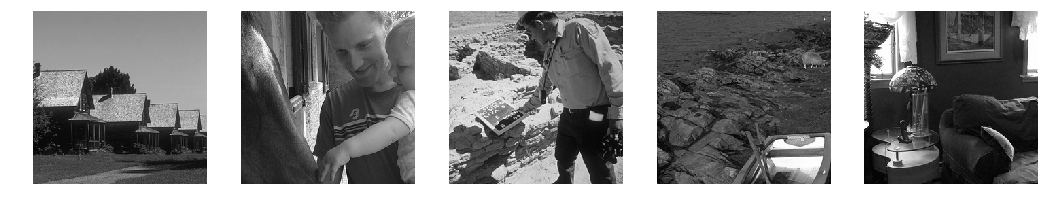

In [5]:
# Visualize samples of clear training images 
fig=plt.figure(figsize=(18, 5))
idxs = np.random.choice(image_num, 5)
imgs = clear_images[idxs]

for i in range(1, 6):    
    fig.add_subplot(1, 5, i)
    plt.imshow(imgs[i - 1][0])
    plt.axis('off')
    plt.gray()
plt.show()

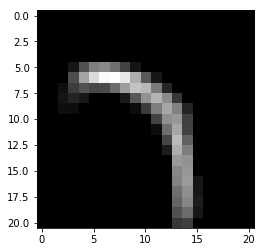

In [6]:
# Visualize kernel
plt.imshow(kernels[0][0])

## Sampling data

In [7]:
def sample(batch_num):
    global image_num
    x_id = np.random.choice(image_num, batch_num)
    xbeg = np.random.choice(image_size - input_size, 1)[0]

    batchx = Variable(torch.from_numpy(clear_images[x_id, :, xbeg : xbeg + input_size , xbeg : xbeg + input_size]).type(dtype), requires_grad=False)
    
    k_id = np.random.choice(range(0, 1), batch_num)
    batchk = Variable(torch.from_numpy(kernels[k_id, :, :, :]).type(dtype), requires_grad=False)

    return batchx, batchk

## Training method
In our work, we take a loss consisting of a content loss and an edge loss:

$\mathcal{L} = \alpha \mathcal{L_c} + \gamma \mathcal{L_e}$, 

where

$\mathcal{L_c}(x, \hat x) = smoothL1(x, \hat x),$

and

$\mathcal{L_e}(x, \hat x) = \|\partial_h{x} - \partial_h{x}\|^2 + \|\partial_v{x} - \partial_v{x}\|^2$.

In [8]:
def alpha_norm(x, xhat, n=2):
	dx = x[:, :, 1:, :] - x[:, :, :-1, :] + 1e-9
	dy = x[:, :, :, 1:] - x[:, :, :, :-1] + 1e-9
	dxh = xhat[:, :, 1:, :] - xhat[:, :, :-1, :] + 1e-9
	dyh = xhat[:, :, :, 1:] - xhat[:, :, :, :-1] + 1e-9
	return ((dx-dxh+1e-9).norm(n) + (dyh-dy + 1e-9).norm(n) + 1e-9)

def train(x, y, optimizer, print_loss=False):

	x_hat = model(y)

	loss = alpha * smoothl1(x_hat, x) + gamma * alpha_norm(x_hat, x, 2)

	optimizer.zero_grad()
	loss.backward()

	if print_loss:
		print('Loss = %f' % loss.data.cpu().numpy())
	loss_recorder.append(float(loss.data.cpu().numpy()))
	
	loss = None
	optimizer.step()
	optimizer.zero_grad()

## Let's start to train!
Training process takes about 10+ mins in our tests.

In [9]:
for epoch in range(0, epoch_num):
	print('Epoch %d' % epoch)
	# Initialize optimizers here
	optimizer = torch.optim.Adam([{'params' : model.parameters()}], lr=lr)
    
	for i in range(iteration_num_per_epoch):
		if False:
			print('Epoch %d Iteration %d' % (epoch, i))
		batchx, batchk = sample(batch_size)
		
		batchy = generate_blur(batchx, batchk, nstr, knstr, False)
		hlfsz = kernel_size // 2 

		batchx = batchx[:, :, hlfsz : patch_size + hlfsz, hlfsz: patch_size + hlfsz]

		if i % 100 ==0:
			print_loss = True
		else:
			print_loss = False
				
		train(batchx, batchy, optimizer, print_loss)

			
		batchx = None
		batchk = None
		batchy = None
		
	# Update learning rate
	lr *= 0.8
torch.save(model.state_dict(), file_store + 'model_self_trained' + '.pkl')

Epoch 0
Loss = 4660.249512
Loss = 3699.637939
Loss = 3329.594727
Loss = 3012.629639
Loss = 2868.780518
Loss = 3144.424072
Loss = 3342.065918
Loss = 2932.427246
Loss = 2816.086914
Loss = 2214.967773
Epoch 1
Loss = 2919.404541
Loss = 3143.962402
Loss = 3204.314209
Loss = 3103.331055
Loss = 2504.045166
Loss = 3165.932129
Loss = 2645.949219
Loss = 3028.444092
Loss = 2993.705078
Loss = 2477.906250
Epoch 2
Loss = 3183.428223
Loss = 3032.194580
Loss = 2391.684814
Loss = 2960.933838
Loss = 3323.851074
Loss = 2822.698975
Loss = 3308.556152
Loss = 2751.244629
Loss = 2507.649170
Loss = 3371.319336
Epoch 3
Loss = 2473.541748
Loss = 2896.308594
Loss = 3047.036621
Loss = 2604.258301
Loss = 2773.999268
Loss = 2592.535889
Loss = 2602.641846
Loss = 3112.573975
Loss = 2862.478516
Loss = 3170.759033
Epoch 4
Loss = 3800.308838
Loss = 2591.608154
Loss = 2726.607910
Loss = 2692.595459
Loss = 2795.469482
Loss = 3305.967285
Loss = 2521.602783
Loss = 2171.825195
Loss = 2960.863525
Loss = 2605.433594
Epoch 5
Lo

## Test using trained model

In [30]:
test_images = test_images[:, :, 25:425, 25:425]
x_val = test_images[0: 1, 0:1 , :, :]
y_val = Variable(torch.from_numpy(x_val).type(dtype), volatile=True, requires_grad=False)

x_hat = model(y_val)
    
xtmp = copy.deepcopy(test_images[0:1])
xtmp[:, 0:1, :, :] = x_hat.data.cpu().numpy()
  
result = copy.deepcopy(test_images[0:1])
result[:, 0:1, :, :] = x_hat.data.cpu().numpy()

blur = test_images

for nn in range(1):
    resultx = ycbcr2rgb(result[nn].transpose(1, 2, 0) * 255.0) / 255.0
    blurx = ycbcr2rgb(blur[nn].transpose(1, 2, 0) * 255.0) / 255.0

/home/likewise-open/SENSETIME/lisiyao1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


## Visualizing deblur results

Blur and deblur:


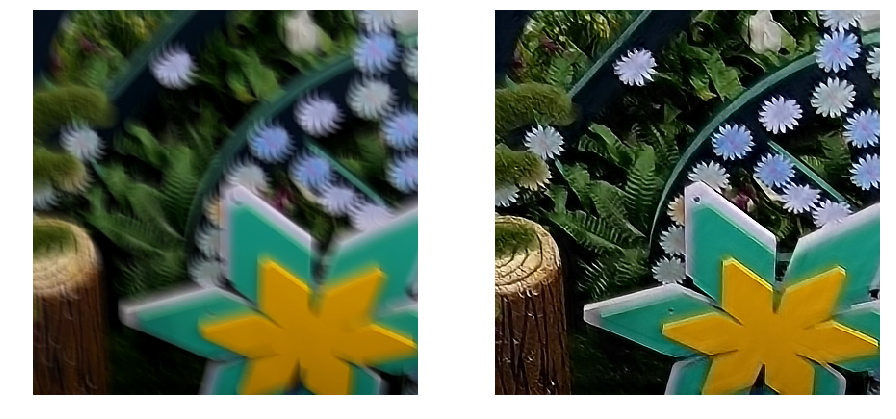

In [34]:
print('Blur and deblur:')
fig=plt.figure(figsize=(40, 10))

   
fig.add_subplot(1, 5, 1)
plt.axis('off')
plt.imshow(blurx)
fig.add_subplot(1, 5, 2)
plt.axis('off')
plt.imshow(resultx)
plt.show()